In [84]:
import sys
import os

import pandas as pd
import numpy as np
import natsort
import random as rn
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf

import matplotlib.pyplot as plt

#Keras

#Sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor
from sklearn.svm import (SVC, SVR)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (AdaBoostRegressor, RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, BaggingRegressor)
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

seed=42
np.random.seed(seed)
rn.seed(seed)
tf.set_random_seed(seed)
dir_path = os.getcwd()

In [72]:
def get_train_from_csv(csv_file):
    '''
    get a numpy array y of labels. the order follows the id of 4 second sample. 
    argument: relative path to the csv_file from the source folder.
    '''
    csv_file = os.path.join(dir_path, csv_file)
    print(f"Reading {csv_file}")
    with open(csv_file, 'r') as csvfile:
        train_reader = pd.read_csv(csvfile)
        train_reader.drop(labels="Id", axis=1, inplace=True)
        
        
    return train_reader.values

def get_target_from_csv(csv_file):
    '''
    get a numpy array y of labels. the order follows the id of 4 second sample. 
    argument: relative path to the csv_file from the source folder.
    '''
    csv_file = os.path.join(dir_path,csv_file)
    with open(csv_file, 'r') as csvfile:
        label_reader = pd.read_csv(csvfile)
        #print("Labels: ", label_reader['id'])
        y = label_reader['y']
        
    y = np.array(y)
    return y



In [73]:

train_folder = os.path.join(dir_path,"data/train/train_emg.csv")
test_folder = os.path.join(dir_path,"data/test/")

train_target = os.path.join(dir_path,'data/train/train_labels.csv')

x_train_emg = get_train_from_csv(train_folder) #List of numpy arrays
y_train = get_target_from_csv(train_target) #Numpy array of labels

Reading /home/ax/master/2018_02/ml/task5/data/train/train_emg.csv


In [112]:
def get_feature(X):
    all_featues = []
    for i in tqdm(range(X.shape[0])):
        features = list()
        # https://ieeexplore.ieee.org/document/7748960
        x_i = X[i,:]
        # Root Mean Square (RMS): RMS of EMG
        features.append(mean_squared_error(x_i, np.zeros(x_i.shape)))
        
        #Integrated Absolute Value (IAV)
        features.append(np.sum(np.abs(x_i)))
        
        # Mean Absolute Value (MAV): MAV feature can be expressed as
        features.append(np.mean(x_i))
        
        # TBD:
        # Modified Mean Absolute Value type 1
        # Modified Mean Absolute Value type 2
        
        # Simple Square Integral (SSI): SSI is calculated as
        features.append(np.sum(x_i ** 2))
        
        # Variance (VAR): VAR is calculated as
        features.append(np.var(x_i))
        
        #The 3rd, 4th and 5th temporal moments
        features.append(np.mean(x_i ** 3))
        features.append(np.mean(x_i ** 4))
        features.append(np.mean(x_i ** 5))
        
        # TBD
        # v-Order 
        
        # Waveform Length
        features.append(np.sum(np.abs(np.diff(x_i))))
        
        # Average Amplitude Change
        features.append(np.mean(np.abs(np.diff(x_i))))
        
        # Difference Absolute Standard Deviation Value
        features.append(np.sqrt(np.mean(np.power(np.diff(x_i), 2))))
        
        # AX BASIC FEATUERS
        features.append(np.std(x_i))
        features.append(np.min(x_i))
        features.append(np.max(x_i))
        features.append(np.sum(x_i < 0.0005))
        
        
        
        all_featues.append(features)
    return np.array(all_featues)


In [113]:
# Create a feature selctor base on a random forest
awake_sample = x_train_emg[y_train == 1]
other_sampes = x_train_emg[y_train != 1]
X_awake = get_feature(awake_sample)
X_other = get_feature(other_sampes)

X_train = np.concatenate((X_awake, X_other))
y_train = np.concatenate((
    np.ones(X_awake.shape[0], dtype=np.int32), 
    np.zeros(X_other.shape[0], dtype=np.int32)
))

Using: 1 features


AttributeError: module 'matplotlib.pyplot' has no attribute 'shoe'

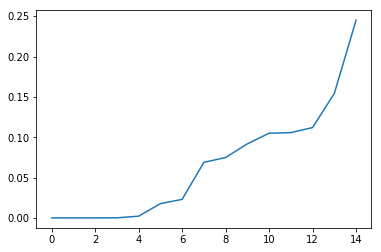

In [115]:

sfm = SelectFromModel(RandomForestClassifier(n_estimators=500, random_state=seed, n_jobs=-1), threshold=0.213)

# Train the classifier
sfm.fit(X_train, y_train)
print(f"Using: {np.sum(sfm.get_support())} features")
plt.plot(np.sort(sfm.estimator_.feature_importances_))
plt.show()

n_features = sfm.transform(X_train).shape[1]

# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.
while n_features > 2:
    sfm.threshold += 0.1
    X_transform = sfm.transform(X_train)
    n_features = X_transform.shape[1]
print(n_features)
# Plot the selected two features from X.
plt.title("Features selected clf sleep with threshold %0.3f." % sfm.threshold)
feature1 = X_transform[y_train == 0][:, 0]
feature2 = X_transform[y_train == 0][:, 1]
plt.plot(feature1, feature2, 'r.')
plt.xlabel("Feature number 1")
plt.ylabel("Feature number 2")
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show()

plt.title("Features selected clf awake with threshold %0.3f." % sfm.threshold)
feature1 = X_transform[y_train == 1][:, 0]
feature2 = X_transform[y_train == 1][:, 1]
plt.plot(feature1, feature2, 'b.')
plt.xlabel("Feature number 1")
plt.ylabel("Feature number 2")
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show()

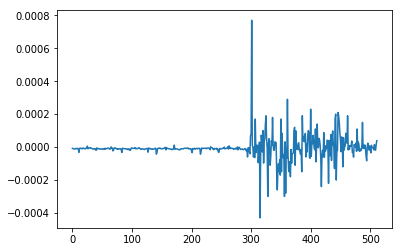

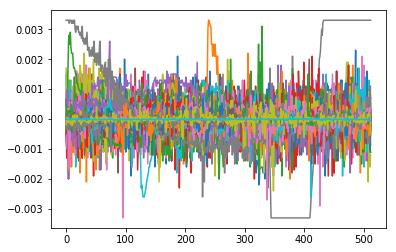

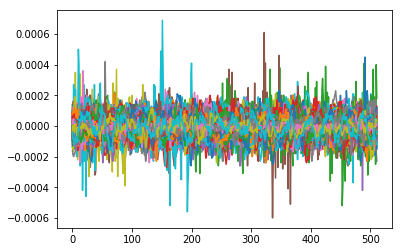

In [77]:
plt.plot(awake_sample[0,:])
plt.show()

for i in range(1000):
    i = np.random.randint(0, awake_sample.shape[0])
    plt.plot(awake_sample[i,:])
plt.show()

for i in range(1000):
    i = np.random.randint(0, other_sampes.shape[0])
    plt.plot(other_sampes[i,:])
plt.show()

In [120]:
rf = RandomForestClassifier(n_estimators=100,
                                       random_state=seed,
                                       n_jobs=-1,
                                       verbose=False)


classifiers = [rf]
classifiers_names = ["RandomForestRegressor", "RandomForestClassifier"  ]

In [121]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
clf_scores_avg = []
clf_scores_std = []

scaler = StandardScaler().fit(X_train)

print("Start")
for clf in classifiers:
    bmac_scores = []
    for train, test in kfold.split(X_train, y_train):
        X_fold_train = X_train[train]
        y_fold_train = y_train[train]
        X_fold_valid = X_train[test]
        y_fold_valid = y_train[test]
        
        # scale 
        X_fold_train = scaler.transform(X_fold_train)
        X_fold_valid = scaler.transform(X_fold_valid)
        
        # fit classifier
        clf.fit(X_fold_train, y_fold_train)
        
        y_pred = clf.predict(X_fold_valid)
        y_true = y_train[test]
        
        bmac_score = balanced_accuracy_score(y_true, y_pred)
        print(f"{len(bmac_scores)}: current balanced_accuracy_score: {bmac_score}")

        bmac_scores.append(bmac_score)
        
    clf_scores_avg.append(np.mean(bmac_scores))
    clf_scores_std.append(np.std(bmac_scores))
    print("========================================")
for i in range(len(classifiers)):
    print(f"{classifiers_names[i]} roc_auc avg score {clf_scores_avg[i]} +/- {clf_scores_std[i]}" )
    

Start
0: current balanced_accuracy_score: 0.8557652786229347
1: current balanced_accuracy_score: 0.8536766427654375
2: current balanced_accuracy_score: 0.8455642821590331
3: current balanced_accuracy_score: 0.8564462745673274
4: current balanced_accuracy_score: 0.8532881801245066
5: current balanced_accuracy_score: 0.8435473984031308
6: current balanced_accuracy_score: 0.8578049312810727
7: current balanced_accuracy_score: 0.8528483849131405
8: current balanced_accuracy_score: 0.8592207051578278
9: current balanced_accuracy_score: 0.8476869641397167
RandomForestRegressor roc_auc avg score 0.8525849042134128 +/- 0.0050300981459103404


In [27]:
#Predict with one classifiers
X_train_importance = sfm.transform(X_train_scaled)
X_test_importance = sfm.transform(X_test_scaled)
print("start fitting")
rf.fit(X_train_importance, Y)

start fitting


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=False,
           warm_start=False)

In [28]:
p_rf = rf.predict(X_test_importance)
print(p_rf)
make_submission("ax_rf_pixelSum_only_feature_2000.csv", p_rf)

[0.421  0.6045 0.798  0.6605 0.4745 0.39   0.6235 0.725  0.784  0.806
 0.187  0.0935 0.4935 0.347  0.1665 0.823  0.516  0.7005 0.803  0.544
 0.517  0.687  0.7335 0.3085 0.6805 0.5605 0.2265 0.675  0.4035 0.31
 0.4145 0.5035 0.4345 0.416  0.44   0.6675 0.6805 0.608  0.8005 0.697
 0.215  0.41   0.325  0.431  0.362  0.787  0.258  0.5635 0.662  0.655
 0.281  0.4345 0.307  0.447  0.278  0.372  0.6435 0.792  0.7915 0.4625
 0.215  0.658  0.8095 0.765  0.7625 0.915  0.5565 0.785  0.6365]
Extracting ids from test set videos
